 ![CellphoneDB Logo](https://www.cellphonedb.org/images/cellphonedb_logo_33.png) CellphoneDB is a publicly available repository of curated receptors, ligands and their interactions.

# Case Example 2. Differential cell-cell communication in spatial niches of the endometrium.

This case study combines:
- CellphoneDB method 3 
- microenvironments (from Spatial Transcriptomics)

to predict cell-cell interactions specific to each "differentiation timepoint of human germ cells into oocytes". See Garcia-Alonso et al 2022 “The second wave of pre-granulosa cells” section for more details. 

**Biological background.** Germ cells and somatic cells synchronise their differentiation using local paracrine factors (Supplementary Figure 1a) in the developing ovary. Single cell transcriptomics analysis revealed four somatic supporting cell states (OSE, preGC-IIa, preGC-IIb and GC) and five germ cell states (PGCs, GCs, oogonia, oogonia-meiotic, oocyte). Spatial transcriptomics analysis revealed a gradient of differentiation (from undifferentiated cells in the cortex to differentiated cells in the medulla) that we discretized into three microenvironments matching the cell differentiation stages (Supplementary Figure 1b-c).

**Research question.** __What are the cell-cell interactions changing along the differentiation trajectory?__
        NOTE there will be germ-somatic interactions constant along the trajectory but we are after those interactions showing a dynamic pattern and could trigger cell identity changes or push differentiation forwards. 
        Also NOTE that there are more cell types in the ovary (for example, stromal, immune, endothelial), but we are going to restrict the analysis to these two lineages because (i) they are in direct contact with each other; and (ii) they have synchronised differentiation.

This notebook assumes that you either know how two **download CellphoneDB database or to create your own database**. If this is not the case, please check `T0_BuildDBfromFiles.ipynb` or `T0_BuildDBfromRelease.ipynb`. In this notebook we will explain how to run CellphoneDB for the **differential expression method**.

#### Check python version

In [1]:
import pandas as pd
import sys
import os

pd.set_option('display.max_columns', 100)

Checking that environment contains a Python >= 3.8 as required by CellphoneDB.

In [2]:
print(sys.version)

3.8.19 | packaged by conda-forge | (default, Mar 20 2024, 12:47:35) 
[GCC 12.3.0]


___
## Input files


Here we aim to retrieve cell-cell interactions involving genes upregulated by any germ or somatic cell state along their differentiation trajectory, with CellPhoneDB method 3. Beside the mandatory dataset's counts and meta files (described [here](https://cellphonedb.readthedocs.io/en/latest/RESULTS-DOCUMENTATION.html#input-files) ), we will provide the following, which configuration is tailored towards our biological question.


- **DEGs file** (mandatory for CellphoneDB method 3), which contains the genes overexpressed by any cell state in any of the two differentiation trajectories (i.e. the germ trajectory and the somatic trajectory). DEGs were calculated using a one-sided Wilcoxon Rank Sum test implemented in the FindAllMarkers function with Seurat v.3.2.2 in a “one versus rest-of-the-lineage” fashion.
>Critical step.
To capture subtle expression differences along each lineage trajectory (the somatic and the germinal), we need to compare each cell state against the other cell states of the same lineage-trajectory in a “one versus rest-of-the-lineage” fashion (i.e. hierarchical differential expression analysis). 
Why “one versus rest-of-the-lineage” and not “one versus all-the-rest”? Because “one versus all-the-rest” does not distinguish cell state-specific from lineage-specific upregulated genes - Here we want to specifically target ligands/receptors upregulated by a specific cell state along their differentiation trajectory, thus our reference should be the cells in the differentiation trajectory (”rest-of-the-lineage”) and not the cells from other lineages (“all-the-rest” including all immune, endothelial, somatic and germ cells together).
- **Microenvironments file.** Because two cells can only interact paracrinally if they colocalise in space and time, we will inform CellphoneDB about the cellular composition of each of the three ovarian microenvironments. CellphoneDB will use this information to restrict the analysis to those cell types that co-localise in each microenvironment (i.e. discard interactions between cells that never co-localise). These spatial niches were identified via spatial transcriptomics analysis where Visium Spatial transcriptomics spots were deconvoluted into single cell type densities using cell2location. 


In [3]:
# Our base directory for the analysis
os.chdir('/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample2_spatialNiches/')

# Path to our input files
cpdb_file_path = '/home/jovyan/cellphonedb_v500_NatProtocol/v5.0.0/cellphonedb.zip'
meta_file_path = '/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample2_spatialNiches/input/dataset_meta.tsv'
counts_file_path = '/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample2_spatialNiches/input/dataset_counts_normloqTransformed.h5ad'
microenvs_file_path = '/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample2_spatialNiches/input/microenvironments.tsv'
degs_file_path = '/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample2_spatialNiches/input/DEGs_upregulated_genes.tsv'
out_path = 'results/'



<span style="color:green">**1)**</span> The **metadata** file is compossed of two columns:
- **barcode_sample**: this column indicates the barcode of each cell in the experiment.
- **cell_type**: this column denotes the cell label assigned.

In [4]:
metadata = pd.read_csv(meta_file_path, sep = '\t')
metadata.head(3)

,Cell,cell_type
0,HCA_A_RepT_RNA13247830_AAACCTGTCAGCCTAA-Mareckova,mes.ePV_1a
1,HCA_A_RepT_RNA13247830_AAACGGGGTAAATGTG-Mareckova,endo.Arterial
2,HCA_A_RepT_RNA13247830_AAACGGGTCACTCCTG-Mareckova,mes.uSMCs


<span style="color:green">**2)**</span>  The **counts** files is a h5ad object from scanpy. The dimensions and order of this object must coincide with the dimensions of the metadata file, i.e. must have the same number of cells in both files.

In [5]:
import anndata

adata = anndata.read_h5ad(counts_file_path)
adata.shape

(13622, 17627)

Check barcodes in metadata and counts are the same.

In [6]:
list(adata.obs.index).sort() == list(metadata['Cell']) \
    .sort()

True

<span style="color:green">**3)**</span> **Differentially expressed genes** file s is a two columns file indicanting which gene up-regulated (or specific) in a cell type. The **first column** corresponds to the cluster name (these match with those in the metadata file) and the **second column** the up-regulated gene. The remaining columns are ignored by CellphoneDB. All genes present in this file will be taken into account, thus the user must provide in this file only those genes considered as up-regulated or relevant for the analysis.

In [7]:
pd.read_csv(degs_file_path, sep = '\t').head(3)

,cluster,gene,p_val_adj,p_val,avg_log2FC,pct.1,pct.2
0,epi.Ciliated,TPPP3,0.0,0.0,3.712861,0.962,0.079
1,epi.Ciliated,C20orf85,0.0,0.0,3.694381,0.960,0.051
2,epi.Ciliated,C9orf24,0.0,0.0,3.458541,0.940,0.042


In [8]:
# How many DEGs each cell type has?
print(pd.read_csv(degs_file_path, sep = '\t')['cluster'].value_counts())

cluster
epi.Ciliated                    510
mes.ePV_1a                      439
immune.eM2                      370
epi.Glandular_secretory_FGF7    369
immune.eM1                      258
mes.Fibroblast_basalis          245
epi.preCiliated                 241
epi.Glandular_secretory         225
mes.ePV_1b                      203
epi.preGlandular                199
epi.SOX9_functionalis_I         189
endo.Arterial                   189
mes.dStromal_late               185
epi.SOX9_basalis                182
mes.eStromal_MMPs               168
immune.uNK1                     165
epi.Luminal                     163
epi.Glandular                   155
immune.uNK3                     133
epi.SOX9_luminal                121
epi.preLuminal                  108
epi.SOX9_functionalis_II        103
endo.Venous                      77
mes.ePV_2                        76
mes.eStromal                     74
mes.dStromal_mid                 71
mes.dStromal_early               69
Name: count, dtype: 

<span style="color:green">**4)**</span> **Micronevironments** defines the cell types that belong to a a given microenvironment. CellphoneDB will only calculate interactions between cells that belong to a given microenvironment. In this file we are defining 11 spatiotemporal microenvionments (spatial = basalis, glands, lumen, vessels; temporal = proliferative, secretory-early and secretory-mid stages).

In [9]:
microenv = pd.read_csv(microenvs_file_path,
                       sep = '\t')
microenv.head(3)

,celltype,microenvironment
0,epi.SOX9_basalis,Proliferative_basalis
1,mes.eStromal,Proliferative_basalis
2,mes.eStromal_MMPs,Proliferative_basalis


Displaying cells grouped per microenvironment

In [10]:
microenv_dic = microenv.groupby('microenvironment')['celltype'].apply(lambda x : list(x.value_counts().index))
microenv_dic

microenvironment
Proliferative_basalis    [epi.SOX9_basalis, mes.eStromal, mes.eStromal_...
Proliferative_glands     [epi.SOX9_functionalis_I, epi.SOX9_functionali...
Proliferative_immune     [immune.eM1, immune.eM2, mes.eStromal, mes.eSt...
Proliferative_lumen                    [epi.SOX9_luminal, epi.preCiliated]
SecretoryEarly_glands               [epi.preGlandular, mes.dStromal_early]
SecretoryEarly_immune       [mes.dStromal_early, immune.uNK3, immune.uNK1]
SecretoryEarly_lumen                        [epi.preLuminal, epi.Ciliated]
SecretoryLate_glands     [epi.Glandular_secretory, epi.Glandular_secret...
SecretoryMid_glands      [epi.Glandular, epi.Glandular_secretory, mes.d...
SecretoryMid_lumen                             [epi.Luminal, epi.Ciliated]
Vessels                  [immune.uNK3, immune.uNK1, immune.eM1, immune....
Name: celltype, dtype: object

____
## Run CellphoneDB with differential analysis (method 3)
The output of this method will be saved in `output_path` and also assigned to the predefined variables.

In [11]:
from cellphonedb.src.core.methods import cpdb_degs_analysis_method

cpdb_results = cpdb_degs_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                            # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                            # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,                        # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    degs_file_path = degs_file_path,                            # mandatory: tsv file with DEG to account.
    counts_data = 'hgnc_symbol',                                # defines the gene annotation in counts matrix.
    microenvs_file_path = microenvs_file_path,                  # optional (default: None): defines cells per microenvironment.
    score_interactions = False,                                  # optional: whether to score interactions or not. 
    threshold = 0.1,                                            # defines the min % of cells expressing a gene for this to be employed in the analysis.
    result_precision = 3,                                       # Sets the rounding for the mean values in significan_means.
    separator = '|',                                            # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                              # Saves all intermediate tables emplyed during the analysis in pkl format.
    output_path = out_path,                                     # Path to save results
    output_suffix = None,                                       # Replaces the timestamp in the output files by a user defined string in the  (default: None)
    threads = 25
    )

[ ][CORE][25/06/24-10:08:37][INFO] [Cluster DEGs Analysis] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample2_spatialNiches/input/dataset_counts_normloqTransformed.h5ad
/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample2_spatialNiches/input/dataset_meta.tsv
/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample2_spatialNiches/input/microenvironments.tsv
/home/jovyan/cellphonedb_v500_NatProtocol/CaseExample2_spatialNiches/input/DEGs_upregulated_genes.tsv
[ ][CORE][25/06/24-10:08:43][INFO] Running Real Analysis
[ ][CORE][25/06/24-10:08:43][INFO] Limiting cluster combinations using microenvironments
[ ][CORE][25/06/24-10:08:43][INFO] Running DEGs-based Analysis
[ ][CORE][25/06/24-10:08:43][INFO] Building results
Saved deconvoluted to results/degs_analysis_deconvoluted_06_25_2024_100843.txt
Saved deconvoluted_percents to results/degs_analysis_deconvoluted_percents_06_25_2024_100843.txt


____
## Results & Outputs

Results are save as files and as a dictionary in the `cpdb_results` variable.

These are the different tables generated. For a full explanation of the outputs, check the documentation [here](https://cellphonedb.readthedocs.io/en/latest/RESULTS-DOCUMENTATION.html#output-files).

In [12]:
list(cpdb_results.keys())

['deconvoluted',
 'deconvoluted_percents',
 'means',
 'relevant_interactions',
 'significant_means',
 'CellSign_active_interactions',
 'CellSign_active_interactions_deconvoluted']

In [13]:
cpdb_results['relevant_interactions'].classification.value_counts()

classification
Adhesion by Collagen/Integrin    93
Signaling by WNT                 89
Signaling by WNT inhibition      27
Signaling by Retinoic Acid       24
Signaling by Chemokines          22
                                 ..
Signaling by Gastrin              1
Signaling by Leptin               1
Signaling by Neuroligin           1
Signaling by Interferon           1
Signaling by Annexin              1
Name: count, Length: 78, dtype: int64

#### Explore CellphoneDB outputs

This function allows to filter CellphoneDB results by specifying: cell types pairs, genes or specific interactions.

In **this example** we are going to filter interactions within the cells in the medulary follicles microenvironemt involved in Notch signalling.

In [14]:
microenv_dic['SecretoryMid_glands']

['epi.Glandular', 'epi.Glandular_secretory', 'mes.dStromal_mid']

In [15]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['epi.Glandular', 'epi.Glandular_secretory'],  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['mes.dStromal_mid'],     # List of cells 2, will be paired to cells 1 (list or 'All').
    query_genes = ['WNT'],                                       # filter interactions based on the genes participating (list).
#     query_interactions = [''],                            # filter intereactions based on their name (list).
    significant_means = cpdb_results['significant_means'],          # significant_means file generated by CellphoneDB.
    deconvoluted = cpdb_results['deconvoluted'],                    # devonvoluted file generated by CellphoneDB.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True,                                             # converts the output into a wide table, removing non-significant interactions
    query_classifications = ['Signaling by WNT']
)

search_results.head(10)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,directionality,classification,interacting_cells,significant_mean
0,DKK1_LRP5,simple:O94907,simple:O75197,DKK1,LRP5,Ligand-Receptor,Signaling by WNT,mes.dStromal_mid|epi.Glandular,1.741
1,DKK1_LRP6,simple:O94907,simple:O75581,DKK1,LRP6,Ligand-Receptor,Signaling by WNT,mes.dStromal_mid|epi.Glandular,1.754
2,DKK1_LRP5,simple:O94907,simple:O75197,DKK1,LRP5,Ligand-Receptor,Signaling by WNT,mes.dStromal_mid|epi.Glandular_secretory,1.732
3,DKK1_LRP6,simple:O94907,simple:O75581,DKK1,LRP6,Ligand-Receptor,Signaling by WNT,mes.dStromal_mid|epi.Glandular_secretory,1.732


> From the results, we can see that several WNT interactions are upregulated in decidualised endometrial fibroblasts (dS) - these interactions are driven by DKK1 a WNT inhibitor

## Plotting

Cell-cell interaction data can be plotted in multiple way; chord plots/heatmaps describing the number of relevant interactions found between pairs of cells or dot plots denoting the specific partners and interacting cells among others. See (Armingol et al 2021 review)[https://www.nature.com/articles/s41576-020-00292-x/figures/4].

Here we use ktplotspy ([kt-plots tutorial](https://ktplotspy.readthedocs.io/en/latest/index.html)) to display CellphoneDB outputs.

In [16]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

#### Summary plots

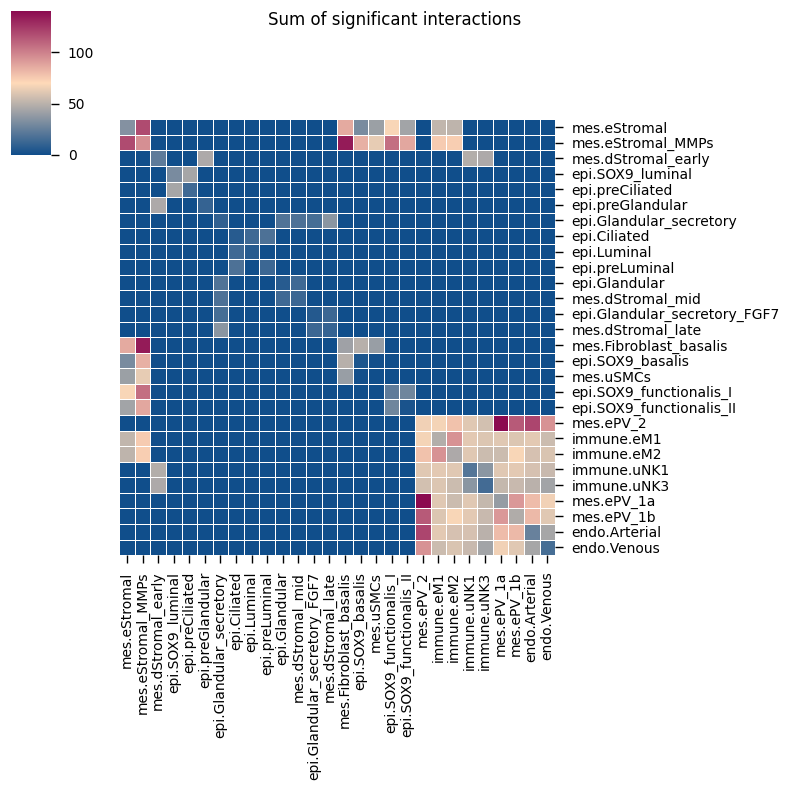

In [17]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['relevant_interactions'],
                      degs_analysis=True,
                      figsize=(8, 8),
                      title="Sum of significant interactions")

Or plot a heatmap per microenvironment

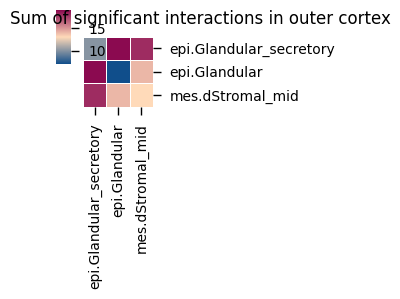

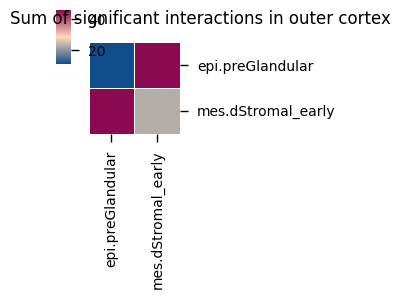

In [18]:
kpy.plot_cpdb_heatmap(pvals = cpdb_results['relevant_interactions'],
                      degs_analysis=True,
                      cell_types=microenv_dic['SecretoryMid_glands'],
                      figsize=(3, 3),
                      title="Sum of significant interactions in outer cortex")

kpy.plot_cpdb_heatmap(pvals = cpdb_results['relevant_interactions'],
                      degs_analysis=True,
                      cell_types=microenv_dic['SecretoryEarly_glands'],
                      figsize=(3, 3),
                      title="Sum of significant interactions in outer cortex")

### Detailed plots

Let's see what are the interactions changing in the glands niche in three timepoints: Proliferative, SecretoryEarly and SecretoryMid

We will do so with Dotplots to visualise the average expression of the interacting molecules (colour of dots) and at the same time its relevance (red stroke - if the interaction contains a differentially expressed gene from the DEG file).

In [19]:
microenv_dic['Proliferative_glands']
microenv_dic['SecretoryEarly_glands']
microenv_dic['SecretoryMid_glands']

['epi.Glandular', 'epi.Glandular_secretory', 'mes.dStromal_mid']

In [ ]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "epi.SOX9_functionalis_II|epi.preGlandular|epi.Glandular",
    cell_type2 = "mes.eStromal|mes.dStromal_early|mes.dStromal_mid", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
#     genes = ["JAG1"],
    figsize = (8,20),
    title = "Interactions between epithelial \nand stroma in the secretory glands",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = False,
#     interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores=True,
)

In [ ]:
from plotnine import facet_wrap

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "epi.SOX9_functionalis_II|epi.preGlandular|epi.Glandular",
    cell_type2 = "mes.eStromal|mes.dStromal_early|mes.dStromal_mid", 
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
#     genes = ["JAG1"],
    figsize = (15,25),
    title = "Interactions between epithelial \nand stroma in the secretory glands",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = False,
#     interaction_scores = cpdb_results['interaction_scores'],
    scale_alpha_by_interaction_scores=True,
)

p + facet_wrap("~ classification", ncol = 2, scales='free_y')

> Interesting to see how stromna cells of the Proliferative and SecretoryEarly glands send IGF and GDF7 to the epithelials, which becomes downregulated in SecretoryMid.  SecretoryMid instead upregulates DDK1, a WNT inhibitor. Similarly, there is IHH signalling epi -> stroma exclusively in the Proliferative fase.


Or alternatively we can plot all the interactions where a gene is involved.

In [ ]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "epi.SOX9_functionalis_II|epi.preGlandular|epi.Glandular|epi.SOX9_luminal|epi.preCiliated|epi.preLuminal|epi.Luminal|epi.Ciliated",
    cell_type2 = "mes.eStromal|mes.dStromal_early|mes.dStromal_mid|epi.SOX9_luminal|epi.preCiliated|epi.preLuminal|epi.Luminal|epi.Ciliated",
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
    genes = ["DKK1", "IGF1", "GDF7"],
    figsize = (10,5),
    title = "Interactions involving DKK1, IGF1 and GDF7 ligands",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = False
)

> This is telling us that DDK1 interactions are exlusive to the cells in the Glands niche of the SecretoryMid timepoint.

In [ ]:
# kpy.plot_cpdb_chord(
#     adata = adata,
#     cell_type1 = ".",
#     cell_type2 = ".", 
#     means = cpdb_results['means'],
#     pvals = cpdb_results['relevant_interactions'],
#     celltype_key = "celltype",
#     deconvoluted = cpdb_results['deconvoluted'],
#     genes=["JAG1"],
#     figsize=(3, 3),
#     labelposition=50,
# )

In [ ]:
kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "epi.SOX9_functionalis_II|epi.preGlandular|epi.Glandular|epi.SOX9_luminal|epi.preCiliated|epi.preLuminal|epi.Luminal|epi.Ciliated",
    cell_type2 = "mes.eStromal|mes.dStromal_early|mes.dStromal_mid|epi.SOX9_luminal|epi.preCiliated|epi.preLuminal|epi.Luminal|epi.Ciliated",
    means = cpdb_results['means'],
    pvals = cpdb_results['relevant_interactions'],
    celltype_key = "celltype",
    genes = ["ALDH"],
    figsize = (10,7),
    title = "Interactions involving Retinoic Acid (RA) ligand",
    max_size = 5,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = False
)